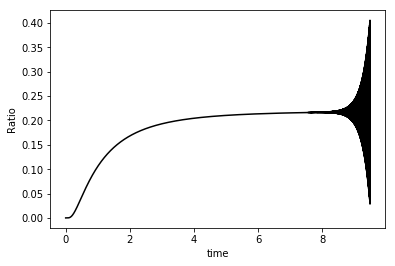

In [254]:
#%%capture
#%matplotlib inline

import numpy as np
from matplotlib import animation
import matplotlib.pylab as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams["animation.html"] = "html5"

def leftShift(x):
    return x[1:]+[x[0]]

def rightShift(x):
    return [x[-1]]+x[:-1]


#--- input parameters
ngrid=1001 #--- spatial discretization
D = 1.0 #--- diffusion factor
dx = 1.0 #--- 
ntime = 9500 #75 #--- time steps
G = 1.0 #--- shear modulus
gammaDot = 0.0 #40 * D / G / dx  #20.0 #1.0 #--- convection rate
tau = 1.0/max(D/dx/dx, gammaDot*G/dx) #0.125 #--- relaxation time scale
dt  = min(0.001,tau) #---
sigma_c = 40.0 #--- stress threshold
sigma = np.linspace(-(ngrid/2)*dx,(ngrid/2)*dx,ngrid) #--- discretized stress
alpha = 1.0 #--- 

#--- delta function
delta = np.array( np.zeros(ngrid))
delta[ngrid/2]=1.0 / dx

#--- define new variables
tau_inv = 1.0 /tau
pref = dx * dt / tau
GtimesGammaDot = G * gammaDot * dt / dx
dx_sq = dx * dx
De = D*dt/dx_sq
dtDelta = dt * delta
dtdx_sq = dt / dx_sq

#--- initial profile
P=np.matrix(np.zeros(ntime*ngrid).reshape(ntime,ngrid))
#P[0,ngrid/2]=1.0
P[0]=np.exp(- (sigma/(sigma_c*0.2))**2)
P[0] /= np.sum(P[0])

#--- integration
D_numerical = 0.5 * dx_sq / dt
d={}
vdt = {}
gg={}
for itime in xrange(ntime - 1 ):
    Ratio_active = np.sum( P[ itime , sigma >= sigma_c ] )
    Gamma = tau_inv * Ratio_active * dx
#    D = alpha * Gamma #(1e-7/0.7)*itime*dt #alpha * Gamma
    assert D*dt/dx_sq <= 0.5, 'D*dt/dx_sq=%s'%(D*dt/dx_sq)
    assert GtimesGammaDot <= 0.5, 'e=%s'%GtimesGammaDot
    assert abs(1.0-np.sum(P[itime]))<1e-7
    gg[itime]=Ratio_active
#    d[itime]=D*dt/dx_sq
#    vdt[itime]=D_numerical
    
#    print GtimesGammaDot
#    p_deriv_1st = np.diff(P[ itime ],n=1,append=P[ itime,0]) #--- 1st derivative
    #--- derivatives
    ls = leftShift(P[ itime ].tolist()[0])
    rs = rightShift(P[ itime ].tolist()[0])
    p_deriv_1st = (np.array(ls) - np.array(rs))*0.5
#    p_deriv_1st = P[ itime ] - np.array(rs)
    
    p_deriv_2nd = np.diff(P[ itime ],n=2,append=P[ itime,0],prepend=P[ itime, -1]) #--- 2nd derivative

    P[ itime + 1 ] = P[ itime ] - GtimesGammaDot * p_deriv_1st  \
                                + ( D + D_numerical ) * dtdx_sq * p_deriv_2nd \
                                -  pref * P[ itime ] * Ratio_active \
                                + dtDelta * Gamma 
        

#plt.yscale('log')
#plt.ylim(1e-2,1)
#plt.xlim(0,3)
plt.xlabel('time')
plt.ylabel('Ratio')
plt.plot(np.array(range(ntime - 1 ))*dt,gg.values(),'-',color='black')
#plt.plot(range(ntime - 1 ),vdt.values(),'-',color='red')


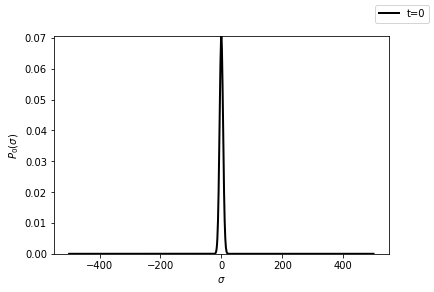

In [255]:
fig=plt.figure()
ax = fig.add_subplot(111)
#ax.set_xlim(-100,100)
ax.set_ylim(0,P[0,:].max())
ax.set_xlabel('$\sigma$')
ax.set_ylabel('$P_0(\sigma)$')
i=0
line = ax.plot(sigma, P[0, :].tolist()[0], color='k', lw=2, label='t=%s'%i)[0]
fig.legend()
def animate(i):
    line.set_ydata(P[i, :])

nframe=100
anim = FuncAnimation(
    fig, animate, interval=20, frames=range(0,ntime-1,(ntime-1)/nframe))


In [256]:
anim